# Compare ideal infomax filter with the retina's horizontal and amacrine cell projective fields

In [76]:
import numpy as np
from scipy.stats import sem

# import my functions
import info_theory_functions as info
from lnl_model_functions import *
from atick_redlich_functions import *
from get_davids_data import *
from image_processing_functions import *

# from scipy.optimize import minimize
# from scipy import fft, arange
# from random import randint
# from cmath import polar
# from numpy.fft import fft2
# from numpy.fft import fftshift
# from sklearn.decomposition import PCA
# from scipy.interpolate import interp1d
# from scipy.optimize import curve_fit


# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
from matplotlib.pyplot import *

# note that nonposx(y) for log plots will no longer work with this package
# I recommend against enabling the whole notebook, since some plots come out funny.
# Instead, just use mpld3.display() at the end of cells you want to interact with.
import mpld3
#mpld3.enable_notebook()

from pylab import rcParams
rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
rcParams['image.interpolation'] = 'nearest'
rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Import natural images

In [2]:
# choose an image path from cd13A (flood plain, water, horizon) or cd01A (baboons, trees, bushes)
im_path     = '/Users/lmcintosh/Documents/Natural_Images/RawData/cd13A' # flood plain, water, horizon
num_images  = 100
patch_size  = None
pixelsToDeg = 92./2 # or 2./92 degrees per pixel (spacing)
spacing     = 1./pixelsToDeg # number of degree spacing between pixels
normalize   = 'divisive'
contrast    = 0.35
patches     = load_images(im_path, num_images, patch_size, square=True, 
                          normalize=normalize, effective_contrast=contrast)

Only 78 files in directory.


In [3]:
allRot  = [spectrum2d(p,spacing=spacing,frequencyFlag=False) for p in patches]
specRot = mean(allRot, axis=0) # average out the amplitude spectrum over all images
frqRot, tmp = spectrum2d(patches[0],spacing=spacing,frequencyFlag=True)
error = [sem([allRot[j][i] for j in range(len(patches))]) for i in range(len(frqRot))]
originalSpectra = specRot
originalErrors  = error
originalFreqs   = frqRot

# Check if horizontal/vertical fft2 scale matches rotavg scale

In [12]:
patches_fft2 = [abs(np.fft.fft2(p))/np.prod(p.shape) for p in patches]
patches_horz = [np.mean(p, axis=0)[:p.shape[0]/2+1] for p in patches_fft2]
patches_vert = [np.mean(p, axis=1)[:p.shape[1]/2+1] for p in patches_fft2]

In [13]:
freqs_horz   = np.linspace(0, 1./(2.*(2./92)), len(patches_horz[0]))
freqs_vert   = np.linspace(0, 1./(2.*(2./92)), len(patches_vert[0]))

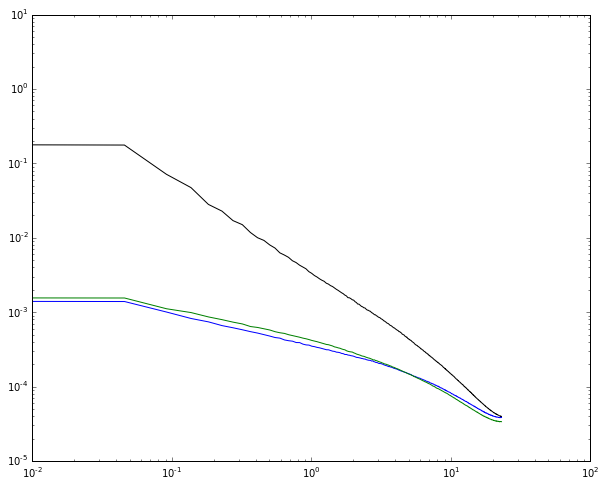

In [23]:
plot(originalFreqs, originalSpectra, 'k')
plot(freqs_horz, np.mean(patches_horz, axis=0), 'b')
plot(freqs_vert, np.mean(patches_vert, axis=0), 'g')
xscale('log')
yscale('log')

# Check different PCA modes (weight space by temporal PCA)

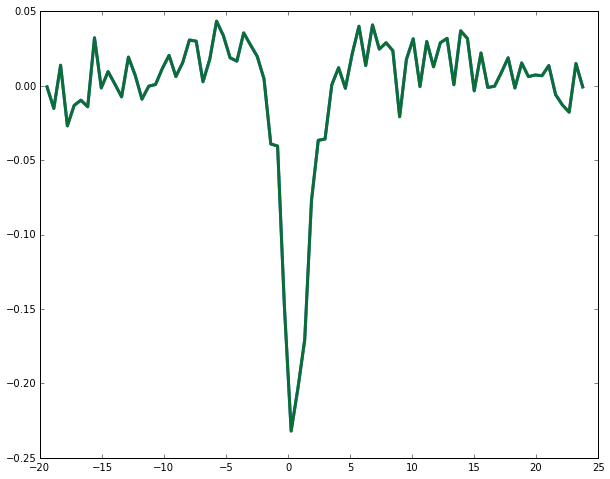

In [27]:
spatial_rfs_time  = load_ganglion_cells(pca_mode='time')
spatial_rfs_space = load_ganglion_cells(pca_mode='space')

plot(spatial_rfs_time[0][0], spatial_rfs_time[0][1], 'b', linewidth=3, alpha=0.8)
plot(spatial_rfs_space[0][0], spatial_rfs_time[0][1], 'g', linewidth=3, alpha=0.8)

## So the two methods are identical

# Get the projective fields of horizontal and amacrine cells

In [53]:
microns_per_deg  = 50.
horz_spatial_pfs = get_horizontal_projective_field(micronsPerDeg=microns_per_deg)
ama_spatial_pfs  = get_amacrine_projective_field(micronsPerDeg=microns_per_deg)

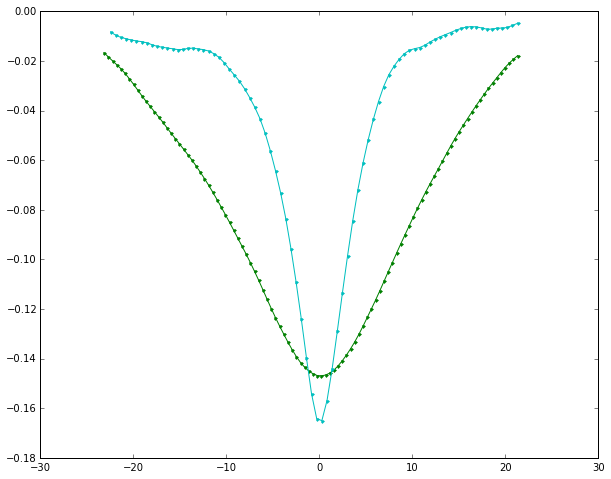

In [54]:
plot(horz_spatial_pfs[1][0], horz_spatial_pfs[1][1],'g.-')
plot(ama_spatial_pfs[0][0], ama_spatial_pfs[0][1],'c.-')

In [55]:
horz_spatial_fft = get_horizontal_projective_fft()
ama_spatial_fft  = get_amacrine_projective_fft()

In [56]:
plot(horz_spatial_fft[1][0], horz_spatial_fft[1][1], 'g.-')
plot(ama_spatial_fft[0][0], horz_spatial_fft[0][1], 'c.-')
mpld3.display()

In [57]:
ganglion_spatial_rfs = load_ganglion_cells()

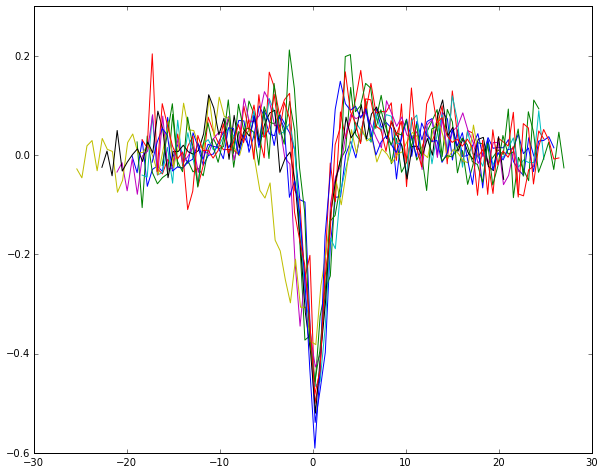

In [58]:
for cell in xrange(10):
    plot(ganglion_spatial_rfs[cell][0], ganglion_spatial_rfs[cell][1])

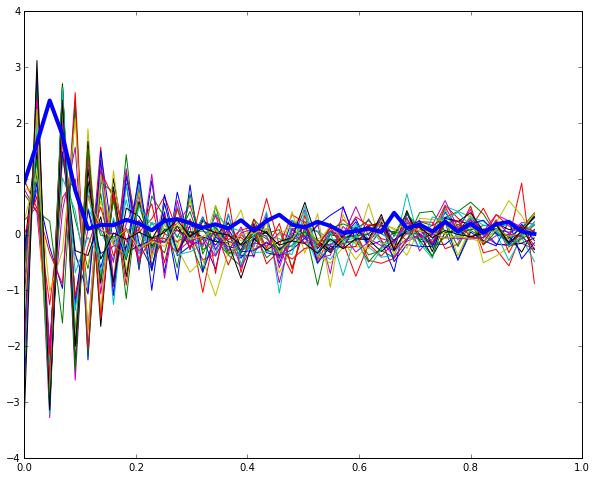

In [91]:
ganglion_ffts = get_fft(ganglion_spatial_rfs, mode='fourier')
for freq, ffti in ganglion_ffts:
    plot(freq, ffti)
plot(freq, abs(np.mean([ffti for _,ffti in ganglion_ffts], axis=0)), linewidth=4)
g_freqs    = freq
g_mean_fft = abs(np.mean([ffti for _,ffti in ganglion_ffts], axis=0))

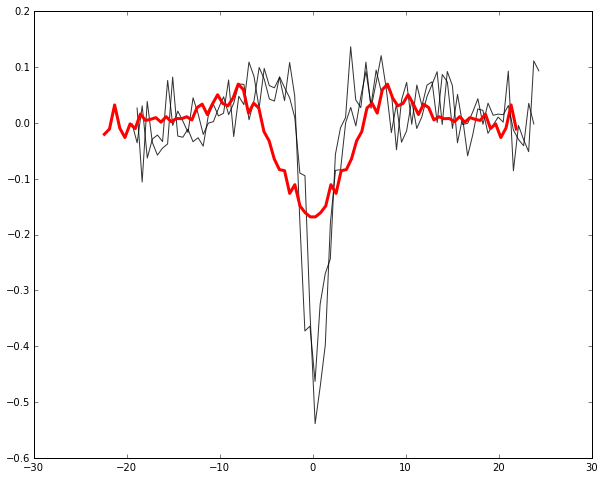

In [97]:
ganglion_rfs = load_ganglion_cells()
spatial_delta = ganglion_rfs[0][0][1] - ganglion_rfs[0][0][0]
plot(ganglion_rfs[0][0], ganglion_rfs[0][1], 'k', linewidth=1, alpha=0.8)
plot(ganglion_rfs[1][0], ganglion_rfs[1][1], 'k', linewidth=1, alpha=0.8)

g_fourier_mean    = np.mean([ffti for _,ffti in ganglion_ffts], axis=0)
g_fourier_mean_2s = np.hstack([g_fourier_mean, g_fourier_mean[1:][::-1]])
figment_ganglion_rf = np.fft.ifft(g_fourier_mean_2s)
figment_ganglion_space = get_space(figment_ganglion_rf, spatial_delta, microns_per_deg=50., scale=False)
plot(figment_ganglion_space, figment_ganglion_rf, 'r', linewidth=3)

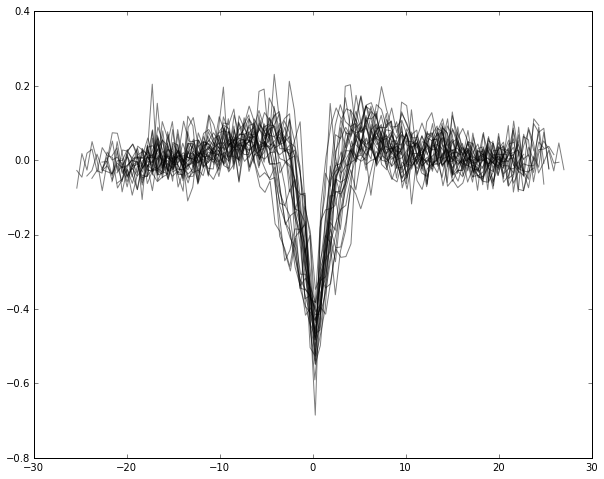

In [98]:
for f, rf in ganglion_rfs:
    plot(f, rf, 'k', alpha=0.5)

## Try clustering according to projection on PCA space

PCA(copy=True, n_components=3, whiten=False)

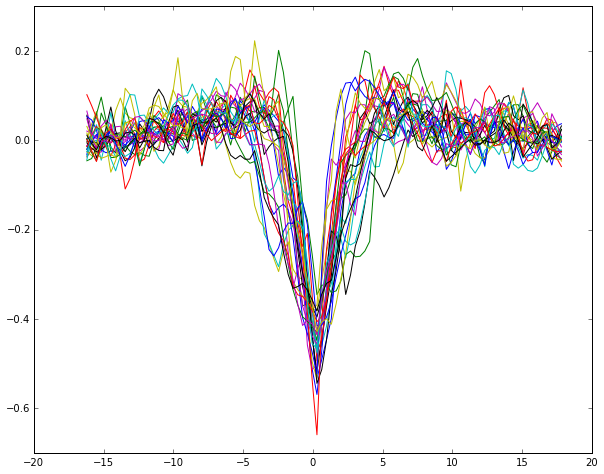

In [216]:
interp_ganglions     = get_interp(ganglion_rfs, nPoints = 100, mode='valid')
aligned_ganglion_rfs = np.vstack([y for x,y in interp_ganglions])
valid_space          = interp_ganglions[0][0]

plot(valid_space, aligned_ganglion_rfs.T)

pca = PCA(n_components=3)
pca.fit(aligned_ganglion_rfs)

In [138]:
pca.explained_variance_

array([ 0.09849361,  0.08718954,  0.03067587])

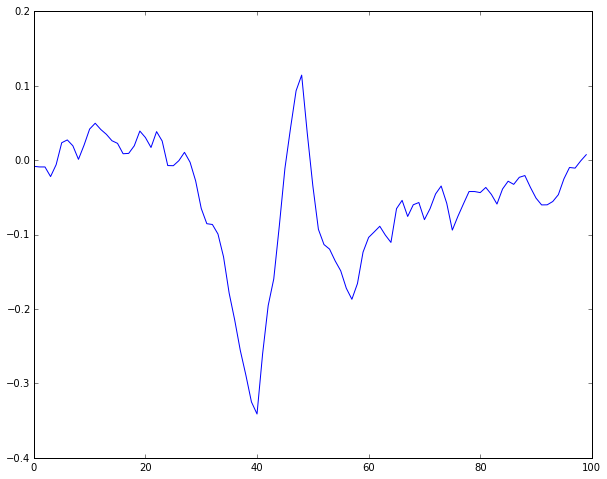

In [144]:
plot(pca.components_[0])

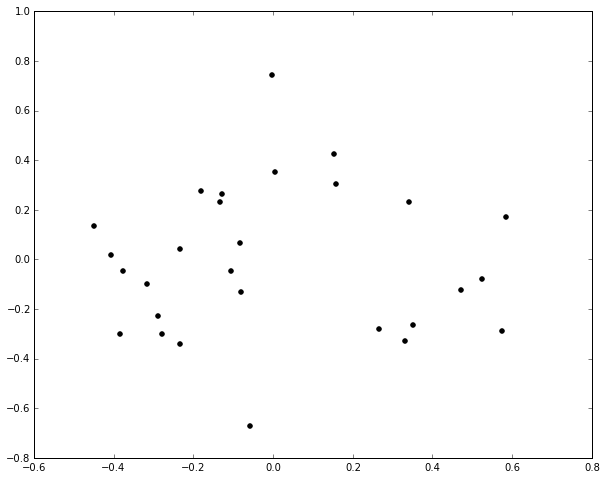

In [145]:
projection_pc1 = np.dot(aligned_ganglion_rfs, pca.components_[0])
projection_pc2 = np.dot(aligned_ganglion_rfs, pca.components_[1])
scatter(projection_pc1, projection_pc2, color='k')

## Cluster ganglion RFs by their width to the first positive number

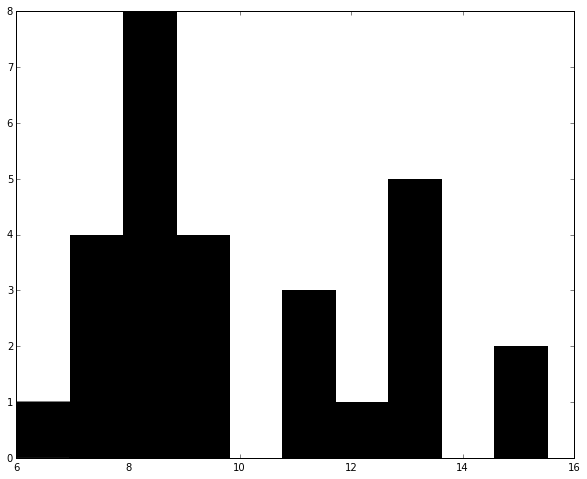

In [177]:
widths = []
for rf in aligned_ganglion_rfs:
    pos_inds = np.array([i for i in xrange(len(rf)) if rf[i] > 0])
    lefties  = 48 - pos_inds
    left_width  = np.min(lefties[lefties>=0])
    right_width = np.min(-lefties[lefties<0])
    #widths.append(np.min(abs(48 - pos_inds)))
    widths.append(np.mean([left_width, right_width]))
counts, bins, _ = hist(widths, color='k')

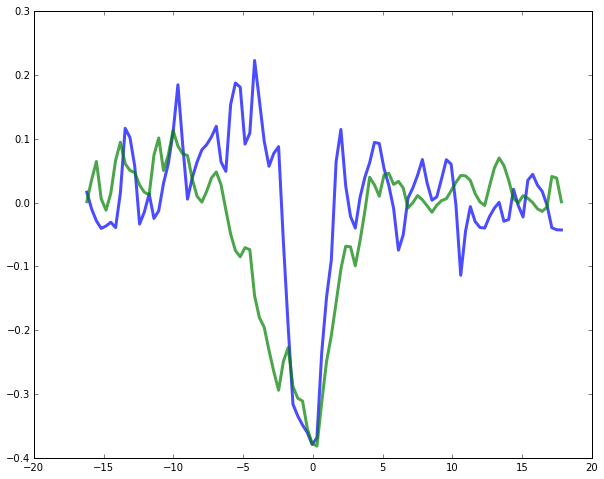

In [217]:
plot(valid_space, aligned_ganglion_rfs[np.argmin(widths)], 'b', linewidth=3, alpha=0.7)
plot(valid_space, aligned_ganglion_rfs[np.argmax(widths)], 'g', linewidth=3, alpha=0.7)

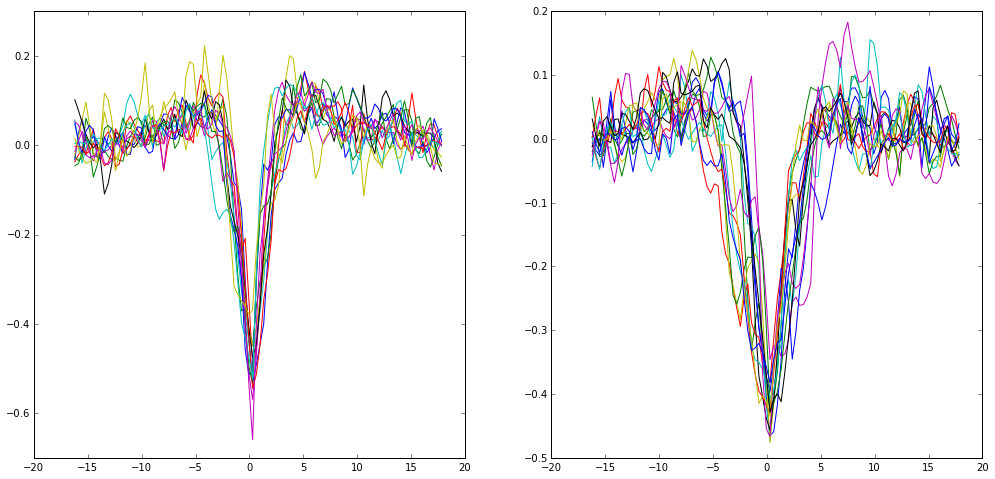

In [218]:
fig = gcf()
fig.set_size_inches((17,8))
subplot(1,2,1)
_ = plot(valid_space, aligned_ganglion_rfs[np.array(widths) < 9].T)
subplot(1,2,2)
_ = plot(valid_space, aligned_ganglion_rfs[np.array(widths) >= 9].T)

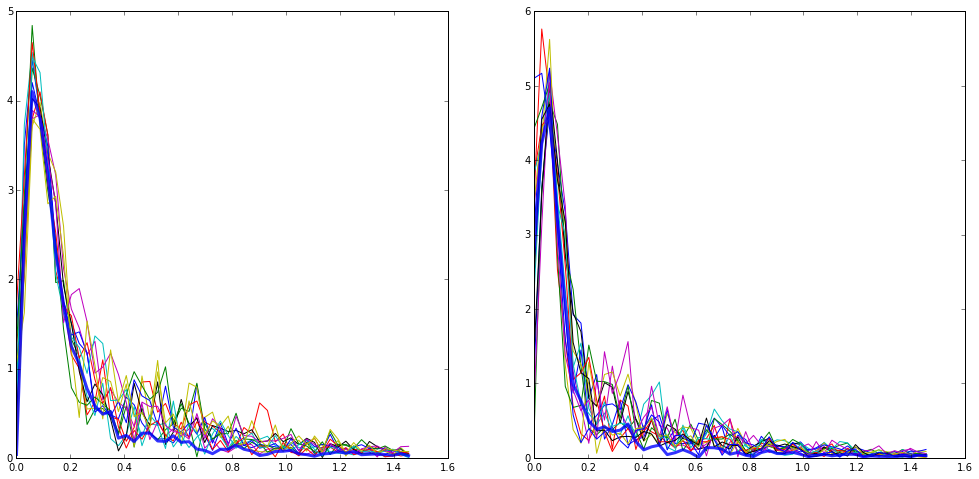

In [225]:
narrow_ganglions = aligned_ganglion_rfs[np.array(widths) < 9]
wide_ganglions   = aligned_ganglion_rfs[np.array(widths) >= 9]
narrow_ganglions_tuples = []
wide_ganglions_tuples   = []
for rf in xrange(narrow_ganglions.shape[0]):
    narrow_ganglions_tuples.append((valid_space, narrow_ganglions[rf]))
for rf in xrange(wide_ganglions.shape[0]):
    wide_ganglions_tuples.append((valid_space, wide_ganglions[rf]))
    
narrow_ganglions_ffts = get_fft(narrow_ganglions_tuples, mode='fourier')
wide_ganglions_ffts   = get_fft(wide_ganglions_tuples, mode='fourier')

fig = gcf()
fig.set_size_inches((17,8))
subplot(1,2,1)
for x,y in narrow_ganglions_ffts:
    plot(x,abs(y))
plot(x, abs(np.mean([y for x,y in narrow_ganglions_ffts], axis=0)), 'b', linewidth=3, alpha=0.8)
# plot(x, abs(np.mean([abs(y) for x,y in narrow_ganglions_ffts], axis=0)), 'k', linewidth=3, alpha=0.8)
subplot(1,2,2)
for x,y in wide_ganglions_ffts:
    plot(x,abs(y))
plot(x, abs(np.mean([y for x,y in wide_ganglions_ffts], axis=0)), 'b', linewidth=3, alpha=0.8)
# plot(x, abs(np.mean([abs(y) for x,y in wide_ganglions_ffts], axis=0)), 'k', linewidth=3, alpha=0.8)

# Get mean horizontal and amacrine ffts

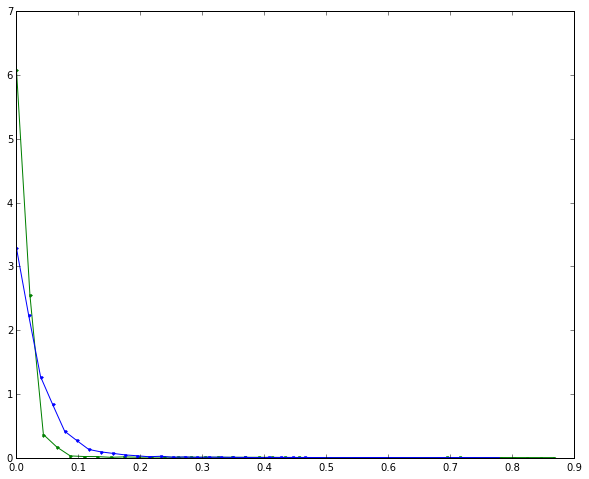

In [89]:
# get raw spatial projective fields
horz_spatial_pfs = get_horizontal_projective_field()
ama_spatial_pfs  = get_amacrine_projective_field()

# align the spatial projective fields
horz_x, horz_mean_pf, horz_err = get_mean(horz_spatial_pfs, nPoints=80)
ama_x, ama_mean_pf, ama_err    = get_mean(ama_spatial_pfs, nPoints=80)

horz_fft = get_fft([(horz_x, horz_mean_pf)], mode='amplitude')
ama_fft  = get_fft([(ama_x, ama_mean_pf)], mode='amplitude')

for freq, ffti in horz_fft:
    plot(freq, ffti, 'g.-')
for freq, ffti in ama_fft:
    plot(freq, ffti, 'b.-')

# Compare ideal and experimental filters  
Note that even controlling for effective contrast, the magnitude of the images makes a huge difference on what the ideal filter is. This is because it changes the power spectrum by quite a bit, which in turn makes the input and output noise either more or less impactful. TO-DO: Compute true SNR from power spectra.

In [184]:
print 'Effective contrast of example image is %5.2f%%.' %(100.*np.std(patches[0])/np.mean(patches[0]))

Effective contrast of example image is 35.00%.


In [8]:
ins = np.logspace(-5, 2, 10)

In [9]:
ins

array([  1.00000000e-05,   5.99484250e-05,   3.59381366e-04,
         2.15443469e-03,   1.29154967e-02,   7.74263683e-02,
         4.64158883e-01,   2.78255940e+00,   1.66810054e+01,
         1.00000000e+02])

In [190]:
input_noise  = 0.0002
output_noise = 0.001
np.mean(originalSpectra**2 / (input_noise * originalSpectra**2 + output_noise))

6.2332743126512238

The relative error from this choice of Lagrangian multiplier is 5.11325749835e-11.


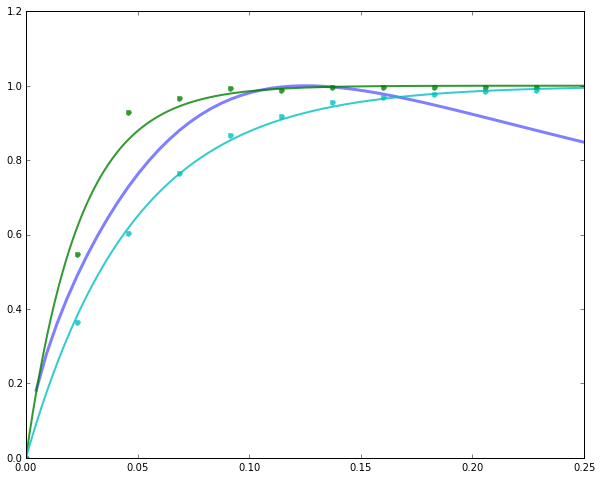

In [174]:
freq_ideal, filt_ideal, freq_expt, filt_expt = compare_to_experiment(originalFreqs, originalSpectra**2, 
                                                                     inputNoise=0.01, outputNoise=0.000001,
                                                                     returnFlag=True, xlimit=[0,0.25], 
                                                                     numPoints=5000, plotFlag='separate')

The relative error from this choice of Lagrangian multiplier is 0.00137551581842.


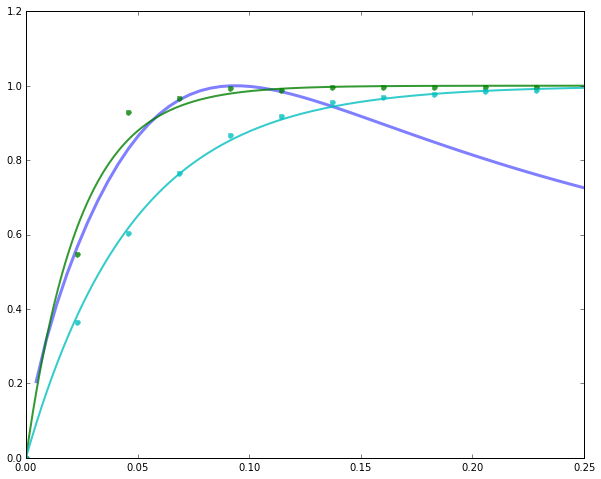

In [227]:
freq_ideal, filt_ideal, freq_expt, filt_expt = compare_to_experiment(originalFreqs, originalSpectra**2, 
                                                                     inputNoise=0.07, outputNoise=0.00000002,
                                                                     returnFlag=True, xlimit=[0,0.25], 
                                                                     numPoints=5000, plotFlag='separate')

The relative error from this choice of Lagrangian multiplier is 0.000620799481753.


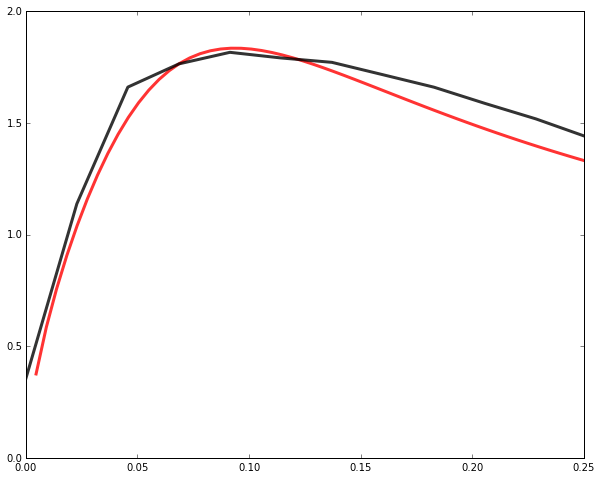

In [241]:
freq_ideal, filt_ideal, freq_expt, filt_expt = compare_to_experiment(originalFreqs, originalSpectra**2, 
                                                                     inputNoise=0.07, outputNoise=0.00000002,
                                                                     center_weighting=1.35, surround_weighting=.35,
                                                                     horz_weighting=0.5, ama_weighting=0.5,
                                                                     center_width=0.5,
                                                                     returnFlag=True, xlimit=[0,0.25], 
                                                                     numPoints=5000, plotFlag='aggregate')

In [242]:
input_noise  = 0.07
output_noise = 0.00000002 #0.000000002
np.mean(originalSpectra**2 / (input_noise * originalSpectra**2 + output_noise))

3.1400201286380738

In [225]:
np.sum(originalSpectra**2)

8.2042583303126175

In [226]:
np.sum(input_noise * originalSpectra**2)

0.57429808312188224

The relative error from this choice of Lagrangian multiplier is 2.87802568075e-08.


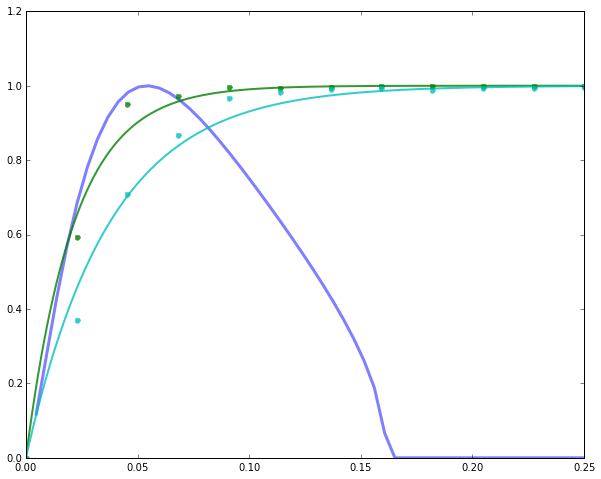

In [1022]:
freq_ideal, filt_ideal, freq_expt, filt_expt = compare_to_experiment(originalFreqs, originalSpectra**2, 
                                                                     inputNoise=0.12, outputNoise=0.35,
                                                                     returnFlag=True, xlimit=[0,0.25], 
                                                                     numPoints=5000, plotFlag='separate')

(0, 1)

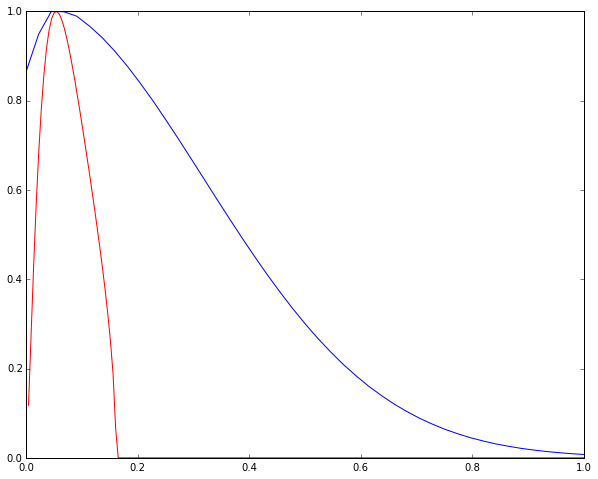

In [1000]:
plot(freq_ideal, filt_ideal/np.nanmax(filt_ideal), 'r')
plot(freq_expt, filt_expt/np.nanmax(filt_expt),'b')
xlim([0,1])

The relative error from this choice of Lagrangian multiplier is 1.84597247827e-08.


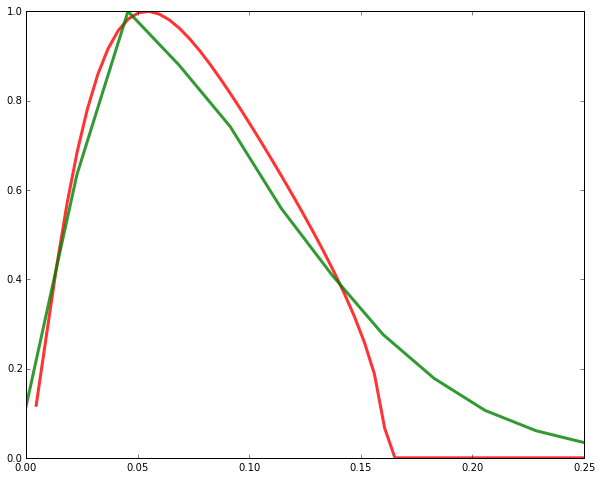

In [1034]:
freq_ideal, filt_ideal, freq_expt_h, filt_expt_h = compare_to_experiment(originalFreqs, originalSpectra**2, 
                                                                     inputNoise=0.12, outputNoise=0.35,
                                                                     center_weighting=6., surround_weighting=.45,
                                                                     horz_weighting=1., ama_weighting=0.,
                                                                     center_width=1.7,
                                                                     returnFlag=True, xlimit=[0,0.25], 
                                                                     numPoints=5000, plotFlag='aggregate')

The relative error from this choice of Lagrangian multiplier is 8.41930469074e-08.


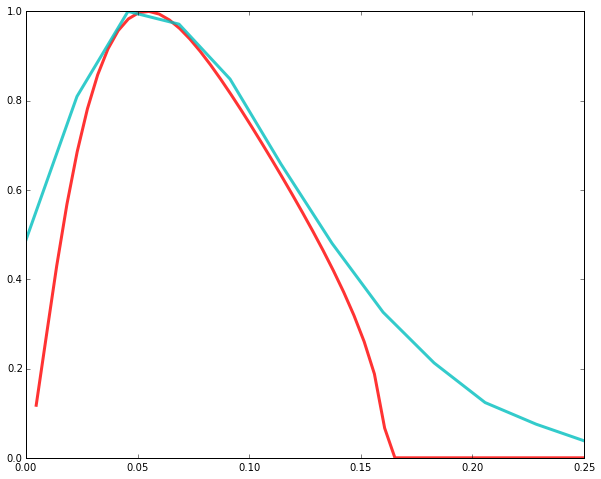

In [1035]:
freq_ideal, filt_ideal, freq_expt_h, filt_expt_h = compare_to_experiment(originalFreqs, originalSpectra**2, 
                                                                     inputNoise=0.12, outputNoise=0.35,
                                                                     center_weighting=6., surround_weighting=.45,
                                                                     horz_weighting=0., ama_weighting=1.,
                                                                     center_width=1.7,
                                                                     returnFlag=True, xlimit=[0,0.25], 
                                                                     numPoints=5000, plotFlag='aggregate')

The relative error from this choice of Lagrangian multiplier is 1.65730865232e-07.


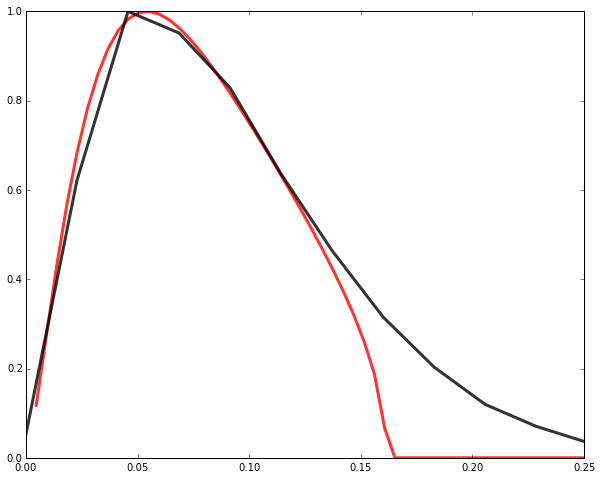

In [1036]:
freq_ideal, filt_ideal, freq_expt_h, filt_expt_h = compare_to_experiment(originalFreqs, originalSpectra**2, 
                                                                     inputNoise=0.12, outputNoise=0.35,
                                                                     center_weighting=6., surround_weighting=.45,
                                                                     horz_weighting=.5, ama_weighting=0.75,
                                                                     center_width=1.7,
                                                                     returnFlag=True, xlimit=[0,0.25], 
                                                                     numPoints=5000, plotFlag='aggregate')

In [1062]:
space, horz_pf, ama_pf = compare_to_experiment(originalFreqs, originalSpectra**2, 
                                                                     inputNoise=0.12, outputNoise=0.35,
                                                                     center_weighting=6., surround_weighting=.45,
                                                                     horz_weighting=.5, ama_weighting=0.75,
                                                                     center_width=1.7,
                                                                     returnFlag=True, xlimit=[0,0.25], 
                                                                     numPoints=5000, plotFlag='aggregate')

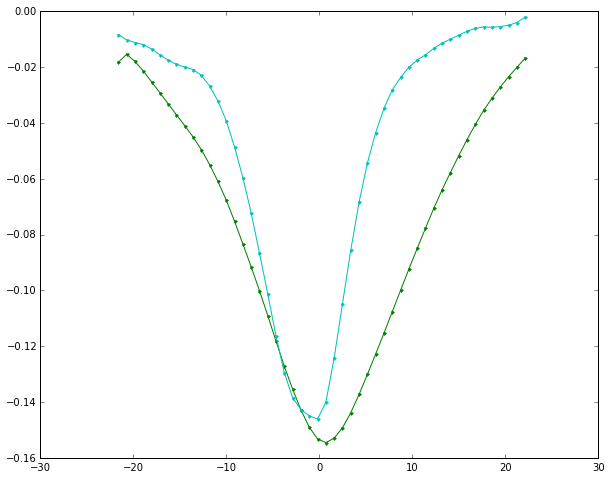

In [1068]:
plot(space, horz_pf, 'g.-')
plot(space, ama_pf, 'c.-')

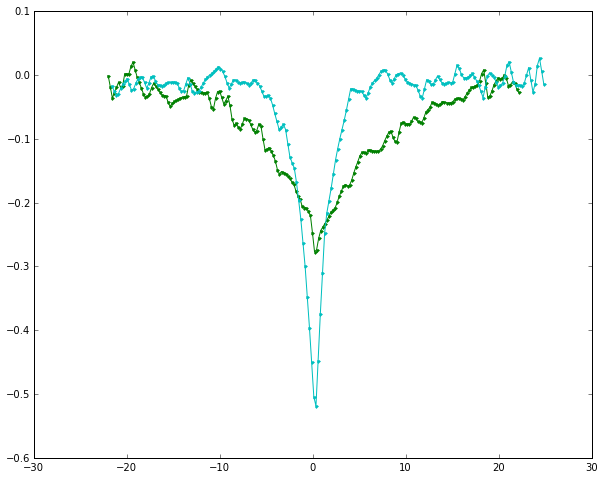

In [1064]:
horz_rfs = load_horizontal_cells()
ama_rfs  = load_amacrine_cells()

aligned_h, mean_horz_rf, horz_rf_sem = get_mean(horz_rfs)
aligned_a, mean_ama_rf, ama_rf_sem   = get_mean(ama_rfs)

plot(aligned_h, mean_horz_rf, 'g.-')
plot(aligned_a, mean_ama_rf, 'c.-')

# 1. Compare bipolar and ganglion cell RFs to family of ideal infomax filters

In [553]:
# get spatial rfs of bipolar and ganglion cells
bipolar_rfs  = load_bipolar_cells()
ganglion_rfs = load_ganglion_cells()

# compute ffts of bipolar and ganglion cells
bipolar_ffts  = get_fft(bipolar_rfs)
ganglion_ffts = get_fft(ganglion_rfs)

# get statistics on the ffts
bipolar_freq, bipolar_mean_fft, bipolar_sem    = get_mean(bipolar_ffts)
ganglion_freq, ganglion_mean_fft, ganglion_sem = get_mean(ganglion_ffts)

# get family of ideal filters
ideal_filts = {}
#input_noises  = np.logspace(-1.,-.42,10)
#output_noises = np.logspace(-.65,-.4,10)
input_noises = [0.09, 0.1, 0.11]
output_noises = [0.28, 0.3, 0.32, 0.35]

moreFreqs, moreSpectra = spectrum_fit(originalFreqs, originalSpectra)
for N in input_noises:
    for N_del in output_noises:
        ideal_filts[(N,N_del)] = unique_soln(moreSpectra**2, N, N_del, verbose=False)

(0, 4)

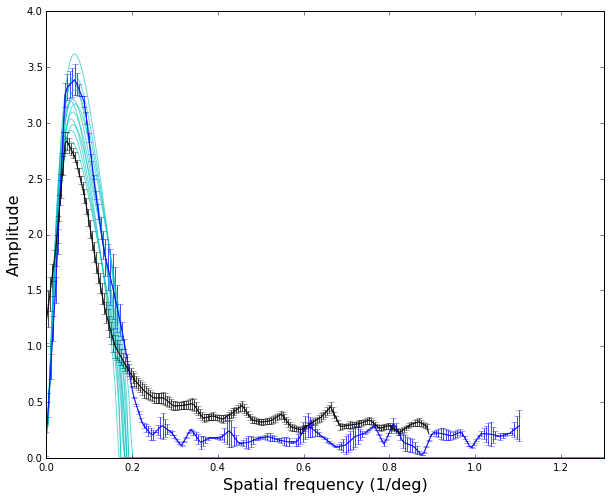

In [555]:
for k in ideal_filts.keys():
    plot(moreFreqs, ideal_filts[k], 'c', alpha=0.6)
# n = 99
# plot(moreFreqs, ideal_filts[ideal_filts.keys()[n]], 'c', alpha=0.8, linewidth=3)
# print ideal_filts.keys()[n]

plot(bipolar_freq, bipolar_mean_fft, 'b', alpha=0.7)
errorbar(bipolar_freq, bipolar_mean_fft, yerr=bipolar_sem, color='b', alpha=0.7)
plot(ganglion_freq, ganglion_mean_fft, 'k', alpha=0.7)
errorbar(ganglion_freq, ganglion_mean_fft, yerr=ganglion_sem, color='k', alpha=0.7)
ylabel('Amplitude', fontsize=16)
xlabel('Spatial frequency (1/deg)', fontsize=16)
xlim([0,1.3])
ylim([0,4])
#mpld3.display()

In [1028]:
# get spatial rfs of bipolar and ganglion cells
bipolar_rfs  = load_bipolar_cells()
ganglion_rfs = load_ganglion_cells()

# compute ffts of bipolar and ganglion cells
bipolar_ffts  = get_fft(bipolar_rfs)
ganglion_ffts = get_fft(ganglion_rfs)

# get statistics on the ffts
bipolar_freq, bipolar_mean_fft, bipolar_sem    = get_mean(bipolar_ffts)
ganglion_freq, ganglion_mean_fft, ganglion_sem = get_mean(ganglion_ffts)

# get family of ideal filters
ideal_filts = {}
#input_noises  = np.logspace(-1.,-.42,10)
#output_noises = np.logspace(-.65,-.4,10)
#input_noises = [0.01, 0.05, 0.1, 0.15, 0.3, 0.4, 0.6]
#output_noises = [0.01, 0.05, 0.1, 0.15, 0.3, 0.4, 0.6]
input_noises = np.logspace(-3,1,10)
output_noises = np.logspace(-3,1,10)

moreFreqs, moreSpectra = spectrum_fit(originalFreqs, originalSpectra)
for N in input_noises:
    for N_del in output_noises:
        ideal_filts[(N,N_del)] = unique_soln(moreSpectra**2, N, N_del, verbose=False)

(0, 1.1)

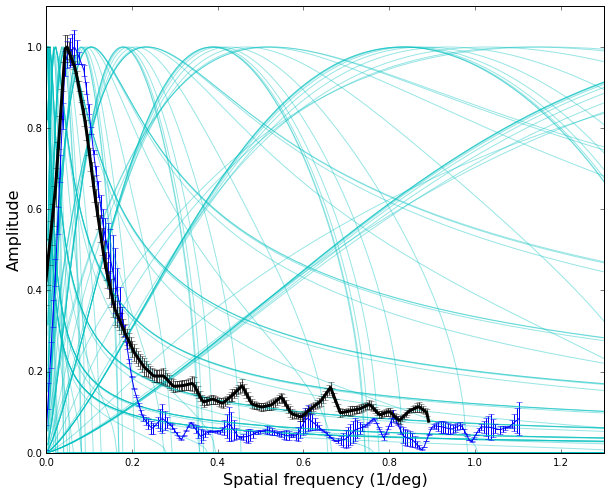

In [1032]:
for k in ideal_filts.keys():
    plot(moreFreqs, ideal_filts[k]/np.nanmax(ideal_filts[k]), 'c', alpha=0.4)
# n = 32
# plot(moreFreqs, ideal_filts[ideal_filts.keys()[n]], 'c', alpha=0.8, linewidth=3)
# print ideal_filts.keys()[n]

b_max = np.nanmax(bipolar_mean_fft)
#plot(bipolar_freq, bipolar_mean_fft/b_max, 'b', alpha=0.7, linewidth=1)
errorbar(bipolar_freq, bipolar_mean_fft/b_max, yerr=(1./b_max)*bipolar_sem, color='b', alpha=1.)
g_max = np.nanmax(ganglion_mean_fft)
plot(ganglion_freq, ganglion_mean_fft/g_max, 'k', alpha=1., linewidth=3)
errorbar(ganglion_freq, ganglion_mean_fft/g_max, yerr=(1./g_max)*ganglion_sem, color='k', alpha=0.7)
ylabel('Amplitude', fontsize=16)
xlabel('Spatial frequency (1/deg)', fontsize=16)
xlim([0,1.3])
ylim([0,1.1])
#mpld3.display()

# The power really matters!

In [612]:
# get spatial rfs of bipolar and ganglion cells
bipolar_rfs  = load_bipolar_cells()
ganglion_rfs = load_ganglion_cells()

# compute ffts of bipolar and ganglion cells
bipolar_ffts  = get_fft(bipolar_rfs)
ganglion_ffts = get_fft(ganglion_rfs)

# get statistics on the ffts
bipolar_freq, bipolar_mean_fft, bipolar_sem    = get_mean(bipolar_ffts)
ganglion_freq, ganglion_mean_fft, ganglion_sem = get_mean(ganglion_ffts)

# get family of ideal filters
ideal_filts = {}
input_noises  = np.logspace(-1.8,-.5,10)
output_noises = np.logspace(-1.8,-.5,10)


moreFreqs, moreSpectra = spectrum_fit(originalFreqs, originalSpectra)
for N in input_noises:
    for N_del in output_noises:
        ideal_filts[(N,N_del)] = unique_soln(moreSpectra, N, N_del, verbose=False)

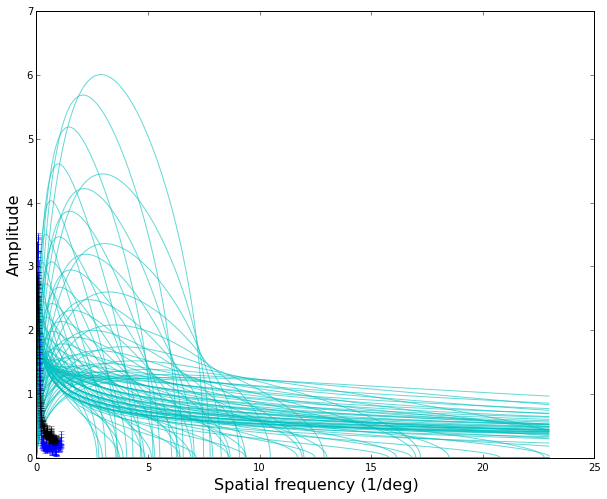

In [613]:
for k in ideal_filts.keys():
    plot(moreFreqs, ideal_filts[k], 'c', alpha=0.6)
# n = 99
# plot(moreFreqs, ideal_filts[ideal_filts.keys()[n]], 'c', alpha=0.8, linewidth=3)
# print ideal_filts.keys()[n]

plot(bipolar_freq, bipolar_mean_fft, 'b', alpha=0.7)
errorbar(bipolar_freq, bipolar_mean_fft, yerr=bipolar_sem, color='b', alpha=0.7)
plot(ganglion_freq, ganglion_mean_fft, 'k', alpha=0.7)
errorbar(ganglion_freq, ganglion_mean_fft, yerr=ganglion_sem, color='k', alpha=0.7)
ylabel('Amplitude', fontsize=16)
xlabel('Spatial frequency (1/deg)', fontsize=16)
#xlim([0,1.3])
#ylim([0,4])
#mpld3.display()

In [650]:
ganglion_rfs = load_ganglion_cells()

In [651]:
space, mean_rf, sem_rf = get_mean(ganglion_rfs)

<Container object of 3 artists>

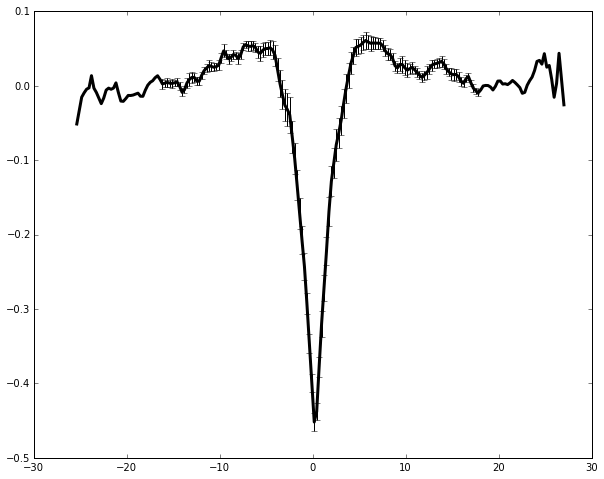

In [815]:
plot(space, mean_rf, 'k', linewidth=3)
errorbar(space, mean_rf, yerr=sem_rf, color='k', alpha=1.)

# 1. Compare normalized bipolar and ganglion RFs to family of infomax filters

In [1039]:
# get spatial rfs of bipolar and ganglion cells
bipolar_rfs  = load_bipolar_cells()
ganglion_rfs = load_ganglion_cells()

# compute ffts of bipolar and ganglion cells
bipolar_ffts  = get_fft(bipolar_rfs)
ganglion_ffts = get_fft(ganglion_rfs)

# get statistics on the ffts
bipolar_freq, bipolar_mean_fft, bipolar_sem    = get_mean(bipolar_ffts)
ganglion_freq, ganglion_mean_fft, ganglion_sem = get_mean(ganglion_ffts)

# get family of ideal filters
ideal_filts = {}
#input_noises  = np.logspace(-1.,-.42,10)
#output_noises = np.logspace(-.65,-.4,10)
# input_noises = [0.01, 0.05, 0.1, 0.15, 0.3, 0.4, 0.6]
# output_noises = [0.01, 0.05, 0.1, 0.15, 0.3, 0.4, 0.6]
input_noises = [0.12]
output_noises = [0.35]

moreFreqs, moreSpectra = spectrum_fit(originalFreqs, originalSpectra)
for N in input_noises:
    for N_del in output_noises:
        ideal_filts[(N,N_del)] = unique_soln(moreSpectra**2, N, N_del, verbose=False)

(0.12, 0.35)


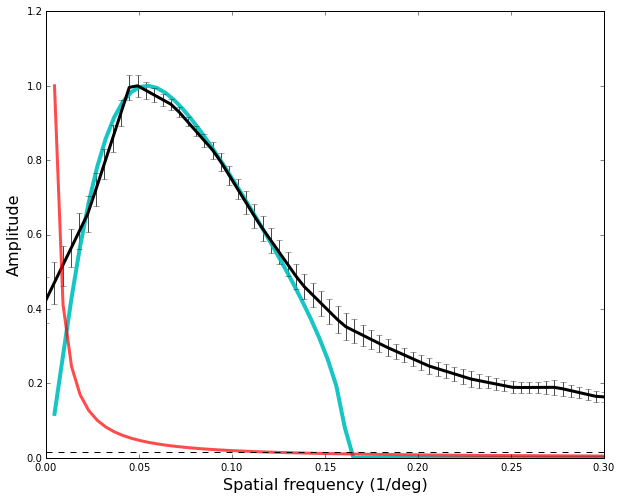

In [1054]:
for k in ideal_filts.keys():
    plot(moreFreqs, ideal_filts[k]/np.nanmax(ideal_filts[k]), 'c', alpha=0.9, linewidth=4) # alpha=0.6
    print k
# for n in xrange(len(input_noises)*len(output_noises)):
#     n = 35
#     plot(moreFreqs, ideal_filts[ideal_filts.keys()[n]]/np.nanmax(ideal_filts[ideal_filts.keys()[n]]), 'c', alpha=0.8, linewidth=3)
#     print ideal_filts.keys()[k]

#b_max = np.nanmax(bipolar_mean_fft)
#plot(bipolar_freq, bipolar_mean_fft/b_max, 'b', alpha=0.7, linewidth=1)
#errorbar(bipolar_freq, bipolar_mean_fft/b_max, yerr=(1./b_max)*bipolar_sem, color='b', alpha=1.)
g_max = np.nanmax(ganglion_mean_fft)
plot(ganglion_freq, ganglion_mean_fft/g_max, 'k', alpha=1., linewidth=3)
errorbar(ganglion_freq, ganglion_mean_fft/g_max, yerr=(1./g_max)*ganglion_sem, color='k', alpha=0.7)

def func(x, a, b):
    return a/(x**b) # adding a constant tends to make moreSpectra have negative numbers

numPoints=5000
popt, pcov  = curve_fit(func, originalFreqs[1:], originalSpectra[1:])
moreFreqs   = np.linspace(0., originalFreqs[-1], numPoints)[1:]
moreSpectra = func(moreFreqs, *popt)

plot(moreFreqs, moreSpectra/np.nanmax(moreSpectra), 'r', linewidth=3, alpha=0.7)
plot(originalFreqs, 0.12**2 *np.ones(len(originalFreqs)), 'k--')

ylabel('Amplitude', fontsize=16)
xlabel('Spatial frequency (1/deg)', fontsize=16)
xlim([0,.3])

# savefig('Figures/' + str(ideal_filts.keys()[n]) + '.png')
savefig('Figures/' + str(ideal_filts[k]) + '.png')
#     plt.close()
#     pause(2)
    #ylim([0,4])
    #mpld3.display()

In [900]:
bipolar_rfs = load_bipolar_cells()
bipolar_x, bipolar_rf, bipolar_sem = get_mean(bipolar_rfs)

In [854]:
np.sum(originalSpectra**2) / (np.sum(0.08*originalSpectra**2) + 0.6)

6.5302815944486774

In [841]:
input_noise  = 0.08
output_noise = 0.000001 #0.000000002
np.mean(originalSpectra**2 / (input_noise * originalSpectra**2 + output_noise))

0.69356919372928172

In [753]:
ganglion_rfs = load_ganglion_cells()
aligned_x, g_mean_rf, g_sem = get_mean(ganglion_rfs)

(-25, 25)

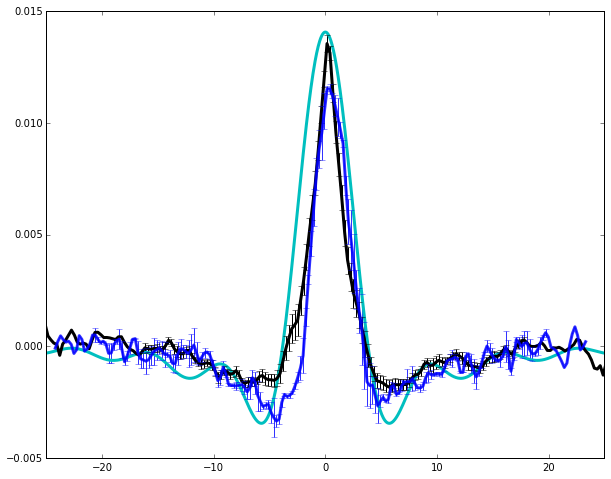

In [902]:
filt = np.fft.ifft(ideal_filts[k])
plot(np.fft.fftshift(np.fft.fftfreq(len(filt), 0.1/moreFreqs[-1])),np.fft.fftshift(filt),'c',linewidth=3)
plot(aligned_x, -.03*g_mean_rf,'k',linewidth=3)
errorbar(space, -.03*mean_rf, yerr=-.03*sem_rf, color='k', alpha=1.)
plot(bipolar_x, -.03*bipolar_rf,'b',linewidth=3, alpha=0.8)
errorbar(bipolar_x, -.03*bipolar_rf, yerr=-.03*bipolar_sem, color='b', alpha=0.8)
xlim([-25,25])

(0, 1.3)

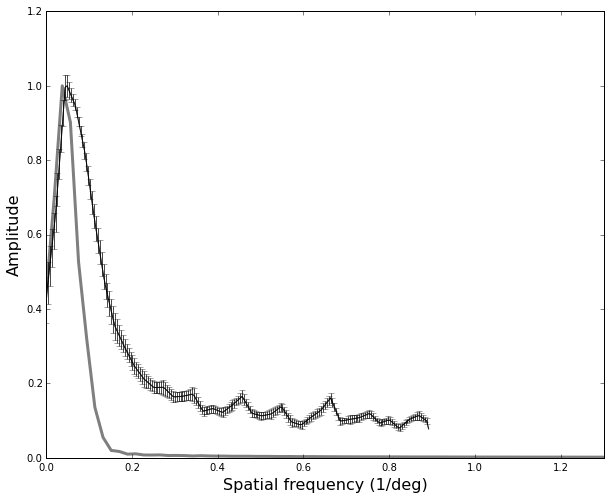

In [791]:
smoothing_filt = gaussian(sigma=2)
smoothed_rf    = np.convolve(g_mean_rf, smoothing_filt, mode='same')
smoothed_ganglion_freq = np.fft.fftfreq(len(smoothed_rf),aligned_x[1]-aligned_x[0])[:len(smoothed_rf)/2]
smoothed_ganglion_fft  = abs(np.fft.fft(smoothed_rf))[:len(smoothed_rf)/2]

plot(smoothed_ganglion_freq, smoothed_ganglion_fft/np.max(smoothed_ganglion_fft), 'k', linewidth=3, alpha=.5)
g_max = np.nanmax(ganglion_mean_fft)
plot(ganglion_freq, ganglion_mean_fft/g_max, 'k', alpha=0.7)
errorbar(ganglion_freq, ganglion_mean_fft/g_max, yerr=(1./g_max)*ganglion_sem, color='k', alpha=0.7)
ylabel('Amplitude', fontsize=16)
xlabel('Spatial frequency (1/deg)', fontsize=16)
xlim([0,1.3])

(-25, 25)

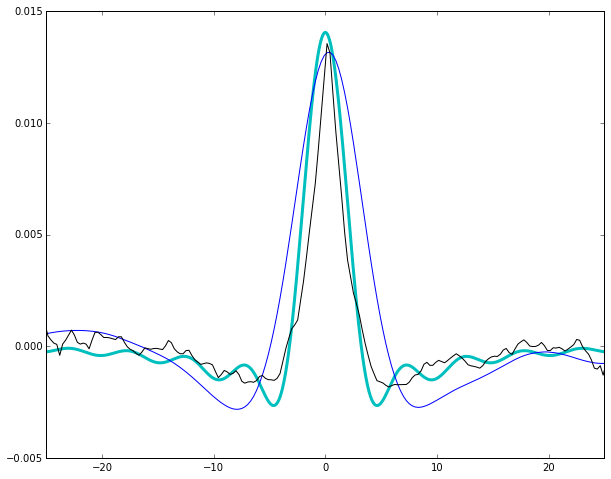

In [800]:
filt = np.fft.ifft(ideal_filts[k])
plot(np.fft.fftshift(np.fft.fftfreq(len(filt), 0.1/moreFreqs[-1])),np.fft.fftshift(filt),'c',linewidth=3)
plot(aligned_x, -.08*smoothed_rf,'b')
plot(aligned_x, -.03*g_mean_rf,'k')
xlim([-25,25])

In [801]:
from scipy import signal
low_pass_filter = signal.firwin(len(ganglion_freq), 0.2, nyq=np.max(ganglion_freq))

(0, 1.3)

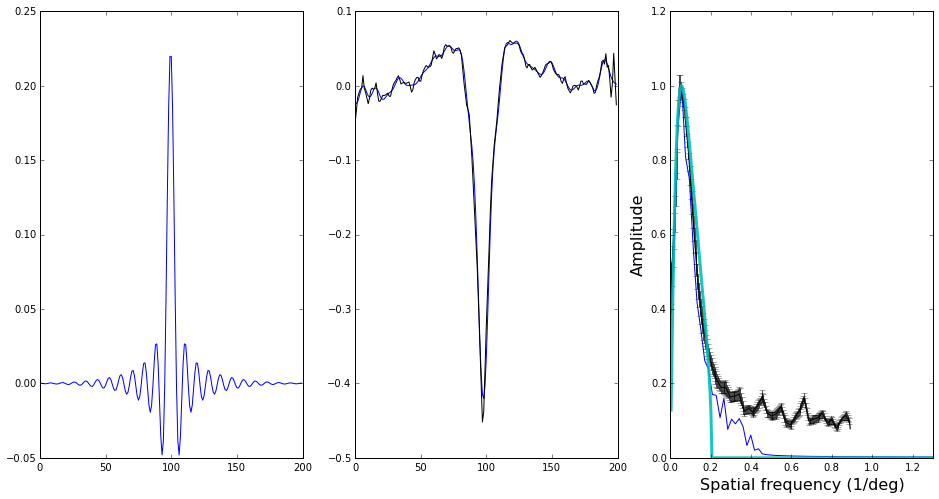

In [811]:
fig = gcf()
fig.set_size_inches((16,8))

subplot(1,3,1)
plot(low_pass_filter)
subplot(1,3,2)
low_pass_g_rf = np.convolve(g_mean_rf, low_pass_filter, mode='same')
plot(low_pass_g_rf)
plot(g_mean_rf, 'k')
subplot(1,3,3)
smoothed_ganglion_freq = np.fft.fftfreq(len(low_pass_g_rf),aligned_x[1]-aligned_x[0])[:len(low_pass_g_rf)/2]
smoothed_ganglion_fft  = abs(np.fft.fft(low_pass_g_rf))[:len(low_pass_g_rf)/2]
plot(smoothed_ganglion_freq, smoothed_ganglion_fft/np.max(smoothed_ganglion_fft),'b')
g_max = np.nanmax(ganglion_mean_fft)
plot(ganglion_freq, ganglion_mean_fft/g_max, 'k', alpha=0.7)
errorbar(ganglion_freq, ganglion_mean_fft/g_max, yerr=(1./g_max)*ganglion_sem, color='k', alpha=0.7)
plot(moreFreqs, ideal_filts[k]/np.nanmax(ideal_filts[k]), 'c', alpha=0.9, linewidth=3)
ylabel('Amplitude', fontsize=16)
xlabel('Spatial frequency (1/deg)', fontsize=16)
xlim([0,1.3])

(0, 1.0)

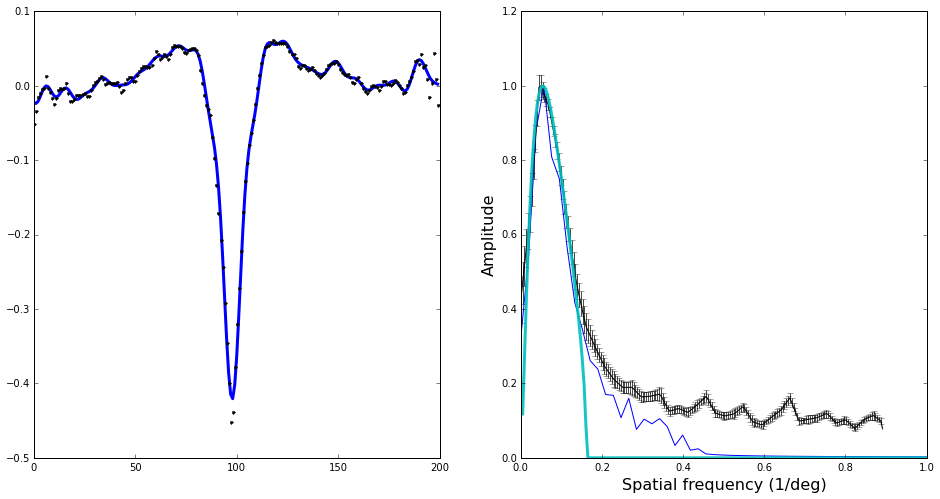

In [931]:
fig = gcf()
fig.set_size_inches((16,8))

subplot(1,2,1)
low_pass_g_rf = np.convolve(g_mean_rf, low_pass_filter, mode='same')
plot(low_pass_g_rf, linewidth=3)
plot(g_mean_rf, 'k.', linewidth=3)
subplot(1,2,2)
smoothed_ganglion_freq = np.fft.fftfreq(len(low_pass_g_rf),aligned_x[1]-aligned_x[0])[:len(low_pass_g_rf)/2]
smoothed_ganglion_fft  = abs(np.fft.fft(low_pass_g_rf))[:len(low_pass_g_rf)/2]
plot(smoothed_ganglion_freq, smoothed_ganglion_fft/np.max(smoothed_ganglion_fft),'b')
g_max = np.nanmax(ganglion_mean_fft)
plot(ganglion_freq, ganglion_mean_fft/g_max, 'k', alpha=0.7)
errorbar(ganglion_freq, ganglion_mean_fft/g_max, yerr=(1./g_max)*ganglion_sem, color='k', alpha=0.7)
plot(moreFreqs, ideal_filts[k]/np.nanmax(ideal_filts[k]), 'c', alpha=0.9, linewidth=3)
ylabel('Amplitude', fontsize=16)
xlabel('Spatial frequency (1/deg)', fontsize=16)
xlim([0,1.])

In [920]:
np.var(patches[1])/(np.var(0.12*patches[1]) + 0.35**2)

7.3046018991806987

In [921]:
15.1*.35 + 2.06

7.344999999999999

# Compare amacrine and horizontal ffts

<Container object of 3 artists>

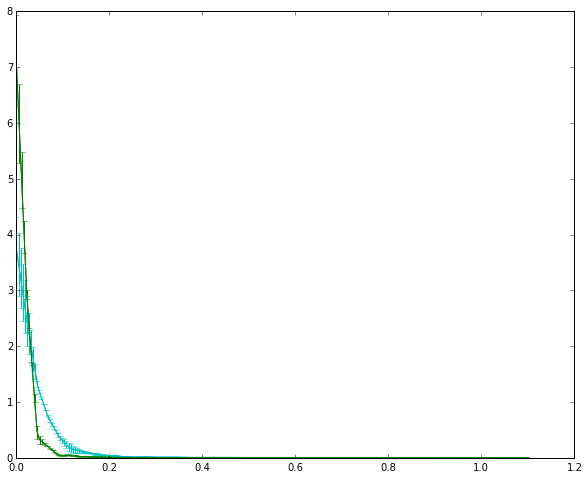

In [407]:
# get list of amacrine and horizontal tuples (freq, fft)
ama_ffts  = get_amacrine_projective_fft()
horz_ffts = get_horizontal_projective_fft()

# compute statistics on them
ama_freq, ama_mean_fft, ama_sem    = get_mean(ama_ffts)
horz_freq, horz_mean_fft, horz_sem = get_mean(horz_ffts)

plot(ama_freq, ama_mean_fft, 'c')
errorbar(ama_freq, ama_mean_fft, yerr=ama_sem, color='c')
plot(horz_freq, horz_mean_fft, 'g')
errorbar(horz_freq, horz_mean_fft, yerr=horz_sem, color='g')

## Take amplitude spectrum after averaging Fourier transforms

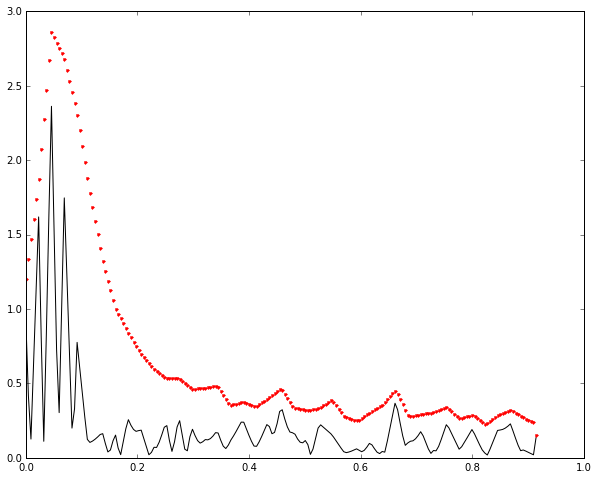

In [63]:
spatial_rfs = load_ganglion_cells()
spatial_ffts = get_fft(spatial_rfs)
spatial_amps = get_fft(spatial_rfs, mode='amplitude')
mean_fft_f, mean_fft, mean_fft_sem = get_mean(spatial_ffts)
mean_amp_f, mean_amp, mean_amp_sem = get_mean(spatial_amps)

plot(mean_fft_f, abs(mean_fft), 'k')
plot(mean_amp_f, mean_amp, 'r.')

### Am I having a problem here with the interpolation?

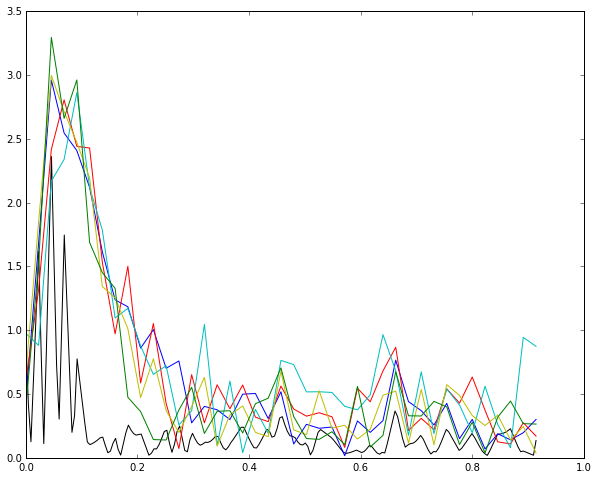

In [68]:
plot(mean_fft_f, abs(mean_fft), 'k')
plot(spatial_ffts[0][0], abs(spatial_ffts[0][1]), 'b')
plot(spatial_ffts[1][0], abs(spatial_ffts[1][1]), 'r')
plot(spatial_ffts[2][0], abs(spatial_ffts[2][1]), 'c')
plot(spatial_ffts[3][0], abs(spatial_ffts[3][1]), 'y')
plot(spatial_ffts[4][0], abs(spatial_ffts[4][1]), 'g')

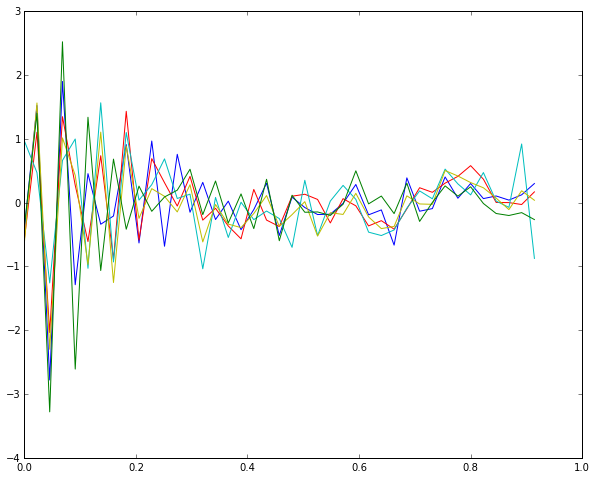

In [87]:
plot(spatial_ffts[0][0], spatial_ffts[0][1], 'b')
plot(spatial_ffts[1][0], spatial_ffts[1][1], 'r')
plot(spatial_ffts[2][0], spatial_ffts[2][1], 'c')
plot(spatial_ffts[3][0], spatial_ffts[3][1], 'y')
plot(spatial_ffts[4][0], spatial_ffts[4][1], 'g')

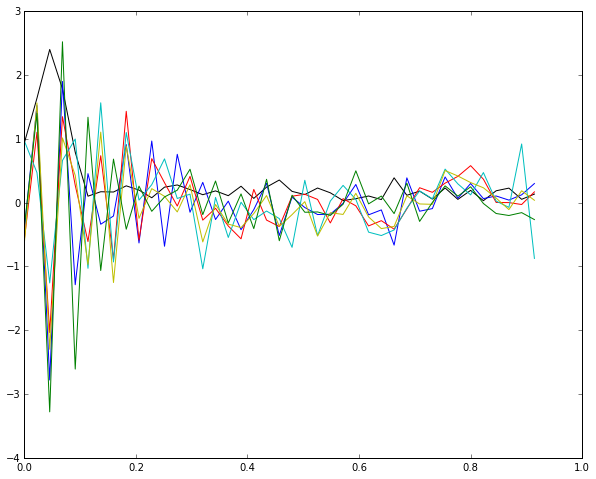

In [93]:
aligned_f, mean_fft, err_fft = get_mean(spatial_ffts, interpolation='linear', nPoints = 41)
plot(aligned_f, abs(mean_fft), 'k')
# plot(spatial_ffts[0][0], abs(spatial_ffts[0][1]), 'b')
# plot(spatial_ffts[1][0], abs(spatial_ffts[1][1]), 'r')
# plot(spatial_ffts[2][0], abs(spatial_ffts[2][1]), 'c')
# plot(spatial_ffts[3][0], abs(spatial_ffts[3][1]), 'y')
# plot(spatial_ffts[4][0], abs(spatial_ffts[4][1]), 'g')
plot(spatial_ffts[0][0], spatial_ffts[0][1], 'b')
plot(spatial_ffts[1][0], spatial_ffts[1][1], 'r')
plot(spatial_ffts[2][0], spatial_ffts[2][1], 'c')
plot(spatial_ffts[3][0], spatial_ffts[3][1], 'y')
plot(spatial_ffts[4][0], spatial_ffts[4][1], 'g')

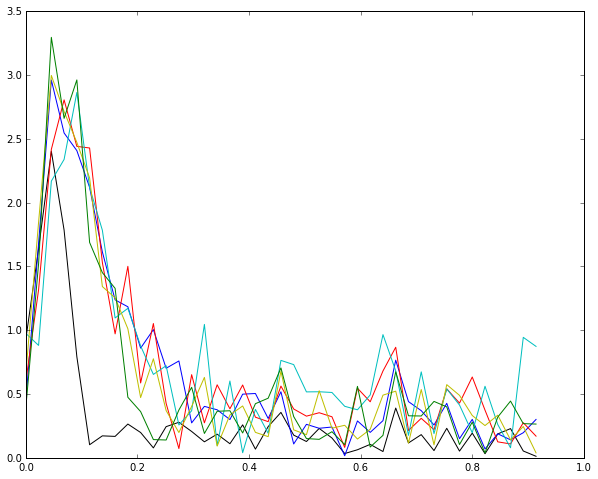

In [95]:
aligned_f, mean_fft, err_fft = get_mean(spatial_ffts, interpolation='linear', nPoints = None)
plot(aligned_f, abs(mean_fft), 'k')
plot(spatial_ffts[0][0], abs(spatial_ffts[0][1]), 'b')
plot(spatial_ffts[1][0], abs(spatial_ffts[1][1]), 'r')
plot(spatial_ffts[2][0], abs(spatial_ffts[2][1]), 'c')
plot(spatial_ffts[3][0], abs(spatial_ffts[3][1]), 'y')
plot(spatial_ffts[4][0], abs(spatial_ffts[4][1]), 'g')
# plot(spatial_ffts[0][0], spatial_ffts[0][1], 'b')
# plot(spatial_ffts[1][0], spatial_ffts[1][1], 'r')
# plot(spatial_ffts[2][0], spatial_ffts[2][1], 'c')
# plot(spatial_ffts[3][0], spatial_ffts[3][1], 'y')
# plot(spatial_ffts[4][0], spatial_ffts[4][1], 'g')

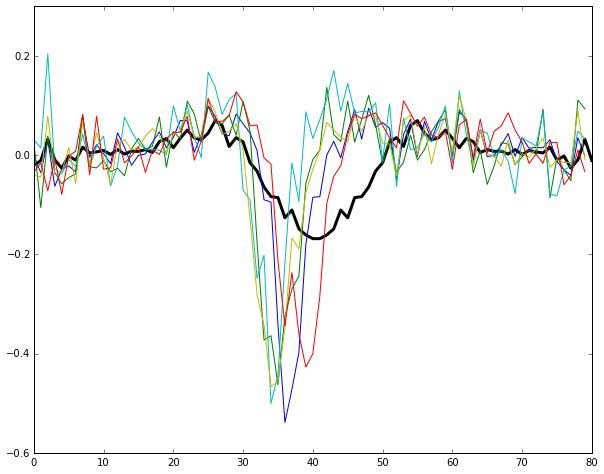

In [111]:
plot(np.fft.ifft(hstack([mean_fft, mean_fft[1:][::-1]])),'k', linewidth=3)
plot(spatial_rfs[0][1],'b')
plot(spatial_rfs[1][1],'g')
plot(spatial_rfs[2][1],'c')
plot(spatial_rfs[3][1],'y')
plot(spatial_rfs[4][1],'r')